# CrimeCast: Forecasting Crime Categories

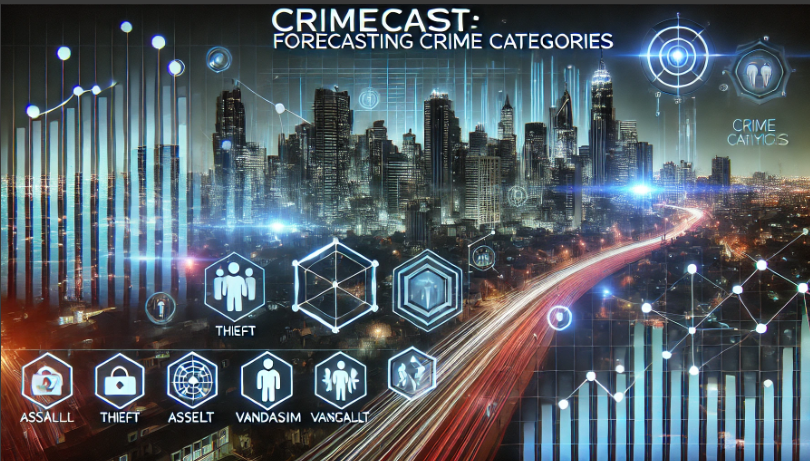

## Data Loading

In [1]:
import numpy as np; import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt; import seaborn as sns

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

## Exploratory Data Analysis

In [2]:
print(train_df.shape)
print("No of dupliates to remove: ",train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)
train_df.reset_index(drop=True, inplace=True)
print(train_df.shape)

(20000, 22)
No of dupliates to remove:  13
(19987, 22)


In [4]:
train_df.sample(6)

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
3265,3600 W MARTIN LUTHER KING JR BL,NaN,34.0110,-118.3351,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,1031.0,3.0,Southwest,363.0,1.0,0344 0421 0906 0334 1402,44.0,F,B,210.0,RESTAURANT/FAST FOOD,500.0,UNKNOWN WEAPON/OTHER WEAPON,AA,Adult Arrest,Property Crimes
13272,1200 S MULLEN AV,NaN,34.0507,-118.3350,11/01/2020 12:00:00 AM,11/01/2020 12:00:00 AM,600.0,7.0,Wilshire,758.0,1.0,0344,31.0,F,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
19759,1200 W 80TH ST,NaN,33.9665,-118.2993,10/19/2020 12:00:00 AM,10/19/2020 12:00:00 AM,930.0,12.0,77th Street,1265.0,2.0,0908 0421 0329 0319 1309,56.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
16612,2400 W PICO BL,NaN,34.0473,-118.2891,02/13/2020 12:00:00 AM,02/11/2020 12:00:00 AM,2250.0,20.0,Olympic,2079.0,2.0,0329 0311 0906 0913,0.0,X,X,247.0,CAR WASH,NaN,NaN,IC,Invest Cont,Property Crimes
6562,600 S HOBART BL,NaN,34.0617,-118.3054,07/04/2020 12:00:00 AM,07/03/2020 12:00:00 AM,1730.0,20.0,Olympic,2024.0,2.0,1822 0329,25.0,F,K,122.0,"VEHICLE, PASSENGER/TRUCK",NaN,NaN,IC,Invest Cont,Property Crimes
6935,16900 DEVONSHIRE ST,NaN,34.2575,-118.5004,09/19/2020 12:00:00 AM,09/19/2020 12:00:00 AM,1600.0,17.0,Devonshire,1757.0,2.0,0701 1202 0344,78.0,F,W,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,Fraud and White-Collar Crimes


Extracting Location column information

In [5]:
def extract_location_data(s):
    street_number = direction = street_name = street_type = None
    try: # steet number
        nt = s.split(' ')[0]
        street_number = nt if int(nt.isdigit()) else None
    except: pass
    try: # direction
        nt = [x.strip() for x in s.split(' ') if x.strip()]
        for x in nt:
            if x.isdigit(): continue
            elif len(x)>1: break
            if x in ['N', 'S', 'E', 'W']:
                direction = x; break
    except: pass
    try: # street type
        nt = s.split('   ')[-1].strip()
        street_type = nt if len(nt)==2 and not(nt.isdigit()) else None
    except: pass
    street_name = None # street name
    nt = [x.strip() for x in s.split('  ') if x.strip()]
    for x in nt:
        test_x = [x.strip() for x in x.split(' ') if x.strip()]
        if len(test_x)==1 and not(street_number and street_number == test_x[0]) and not(street_type and street_type == test_x[0]):
            street_name = x; break
        elif not(street_number and street_number in test_x):
            street_name = x; break
    return street_number, direction, street_name, street_type

def split_location_column(df):
    parsed_data = []
    for idx, row in df.iterrows():
        string = row['Location']
        street_number, direction, street_name, street_type = extract_location_data(string)
        parsed_data.append({
            'Location': string,
            'Street_Number': street_number,
            'Direction': direction,
            'Street_Name': street_name,
            'Street_Type': street_type
        })
    location_df = pd.DataFrame(parsed_data, index=df.index)
    df = df.drop(columns=['Location'])
    df = pd.concat([location_df,df], axis=1)
    return df

In [6]:
train_df = split_location_column(train_df)
train_df.sample(6)

,Location,Street_Number,Direction,Street_Name,Street_Type,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
15255,12TH,None,None,12TH,None,WESTLAKE,34.0482,-118.2804,09/29/2020 12:00:00 AM,08/02/2020 12:00:00 AM,1020.0,2.0,Rampart,285.0,1.0,2000 1814 1309 0432 0913,49.0,M,H,101.0,STREET,307.0,VEHICLE,IC,Invest Cont,Violent Crimes
10200,2900 FRANCIS AV,2900,None,FRANCIS,AV,NaN,34.0568,-118.2916,08/12/2020 12:00:00 AM,08/06/2020 12:00:00 AM,700.0,20.0,Olympic,2049.0,1.0,0329 0344 1822,39.0,F,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,Property Crimes
13993,1000 S OLIVE ST,1000,S,OLIVE,ST,NaN,34.0420,-118.2599,09/25/2020 12:00:00 AM,09/19/2020 12:00:00 AM,211.0,1.0,Central,182.0,1.0,0344 1251 1822 0377,20.0,M,W,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont,Property Crimes
11264,1300 W SUNSET BL,1300,W,SUNSET,BL,NaN,34.0685,-118.2460,07/10/2020 12:00:00 AM,07/10/2020 12:00:00 AM,845.0,1.0,Central,101.0,1.0,1309 1822 0430 1100,31.0,F,B,102.0,SIDEWALK,102.0,HAND GUN,AA,Adult Arrest,Violent Crimes
14449,1400 S POINT VIEW ST,1400,S,POINT VIEW,ST,NaN,34.0517,-118.3701,11/25/2020 12:00:00 AM,11/25/2020 12:00:00 AM,1850.0,7.0,Wilshire,762.0,2.0,0603 0447 0416 1202,70.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes
5198,3500 CARIBETH DR,3500,None,CARIBETH,DR,NaN,34.1348,-118.4919,02/16/2020 12:00:00 AM,02/16/2020 12:00:00 AM,851.0,10.0,West Valley,1097.0,2.0,0421 1912 1822,34.0,M,W,501.0,SINGLE FAMILY DWELLING,511.0,VERBAL THREAT,IC,Invest Cont,Crimes against Public Order


In [7]:
train_df.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,7330.000000
mean,33.940599,-117.892777,1352.428779,10.834442,1129.623005,1.418222,30.149497,297.179767,366.341201
std,2.127496,7.380116,645.997471,6.032913,603.310792,0.493279,21.861242,211.996875,120.495174
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.322900,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165050,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19987 entries, 0 to 19986
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               19987 non-null  object 
 1   Street_Number          16540 non-null  object 
 2   Direction              7043 non-null   object 
 3   Street_Name            19987 non-null  object 
 4   Street_Type            18180 non-null  object 
 5   Cross_Street           3447 non-null   object 
 6   Latitude               19987 non-null  float64
 7   Longitude              19987 non-null  float64
 8   Date_Reported          19987 non-null  object 
 9   Date_Occurred          19987 non-null  object 
 10  Time_Occurred          19987 non-null  float64
 11  Area_ID                19987 non-null  float64
 12  Area_Name              19987 non-null  object 
 13  Reporting_District_no  19987 non-null  float64
 14  Part 1-2               19987 non-null  float64
 15  Mo

In [10]:
train_df.isnull().mean() * 100

Location                  0.000000
Street_Number            17.246210
Direction                64.762095
Street_Name               0.000000
Street_Type               9.040877
Cross_Street             82.753790
Latitude                  0.000000
Longitude                 0.000000
Date_Reported             0.000000
Date_Occurred             0.000000
Time_Occurred             0.000000
Area_ID                   0.000000
Area_Name                 0.000000
Reporting_District_no     0.000000
Part 1-2                  0.000000
Modus_Operandi           13.698904
Victim_Age                0.000000
Victim_Sex               13.118527
Victim_Descent           13.118527
Premise_Code              0.000000
Premise_Description       0.025016
Weapon_Used_Code         63.326162
Weapon_Description       63.326162
Status                    0.000000
Status_Description        0.000000
Crime_Category            0.000000
dtype: float64

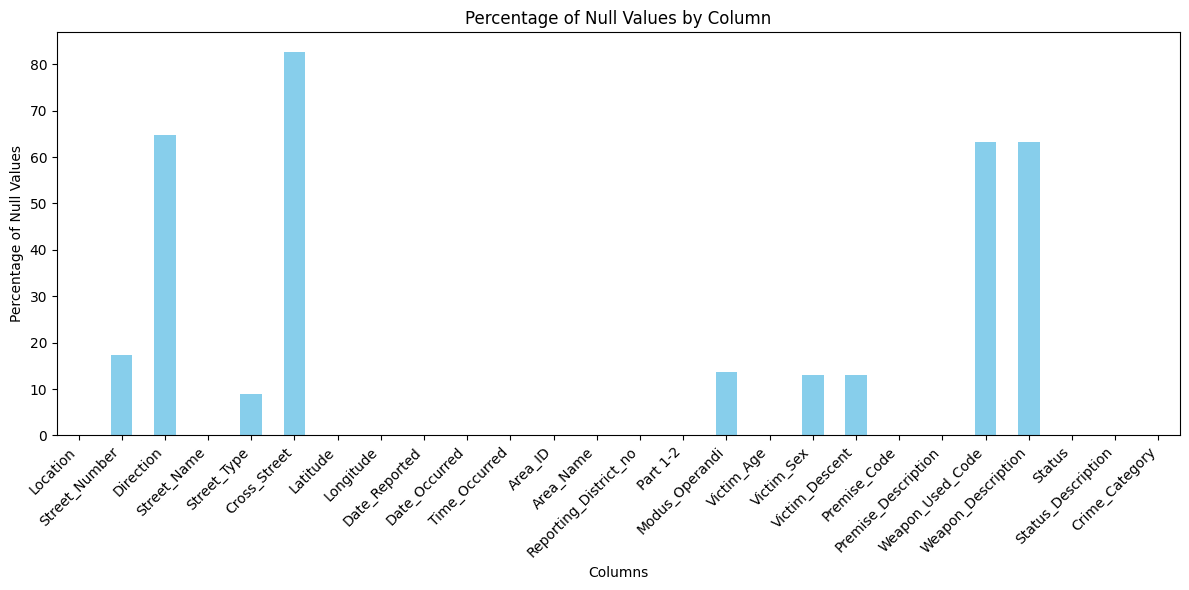

In [11]:
null_percentage = train_df.isnull().mean() * 100
plt.figure(figsize=(12, 6))
null_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Null Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Direction, Cross_Street, Weapon_Used_Code, and Weapon_Description have high percentages of missing values in your dataset. This suggests potential issues with the reliability and completeness of these features. However, from the perspective of domain knowledge in crime reporting, Weapon_Used_Code can still provide valuable insights.

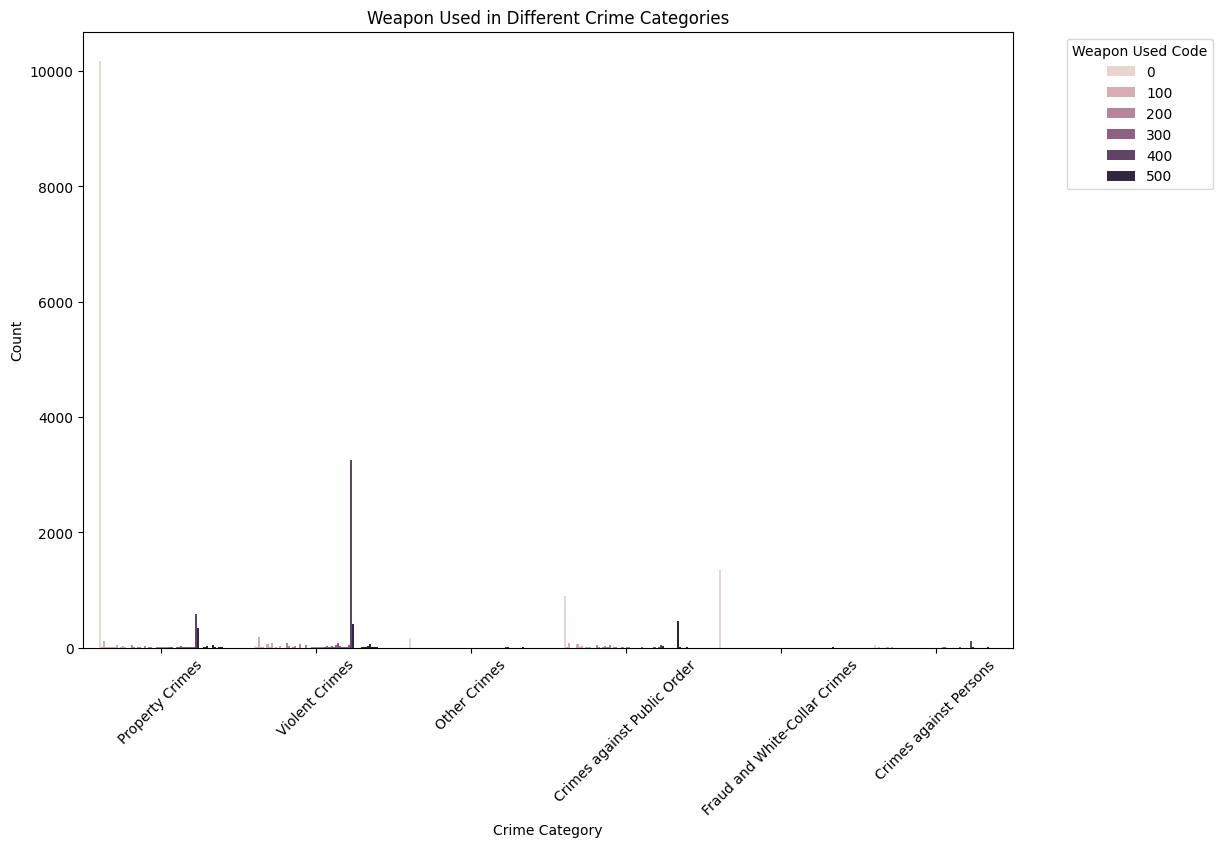

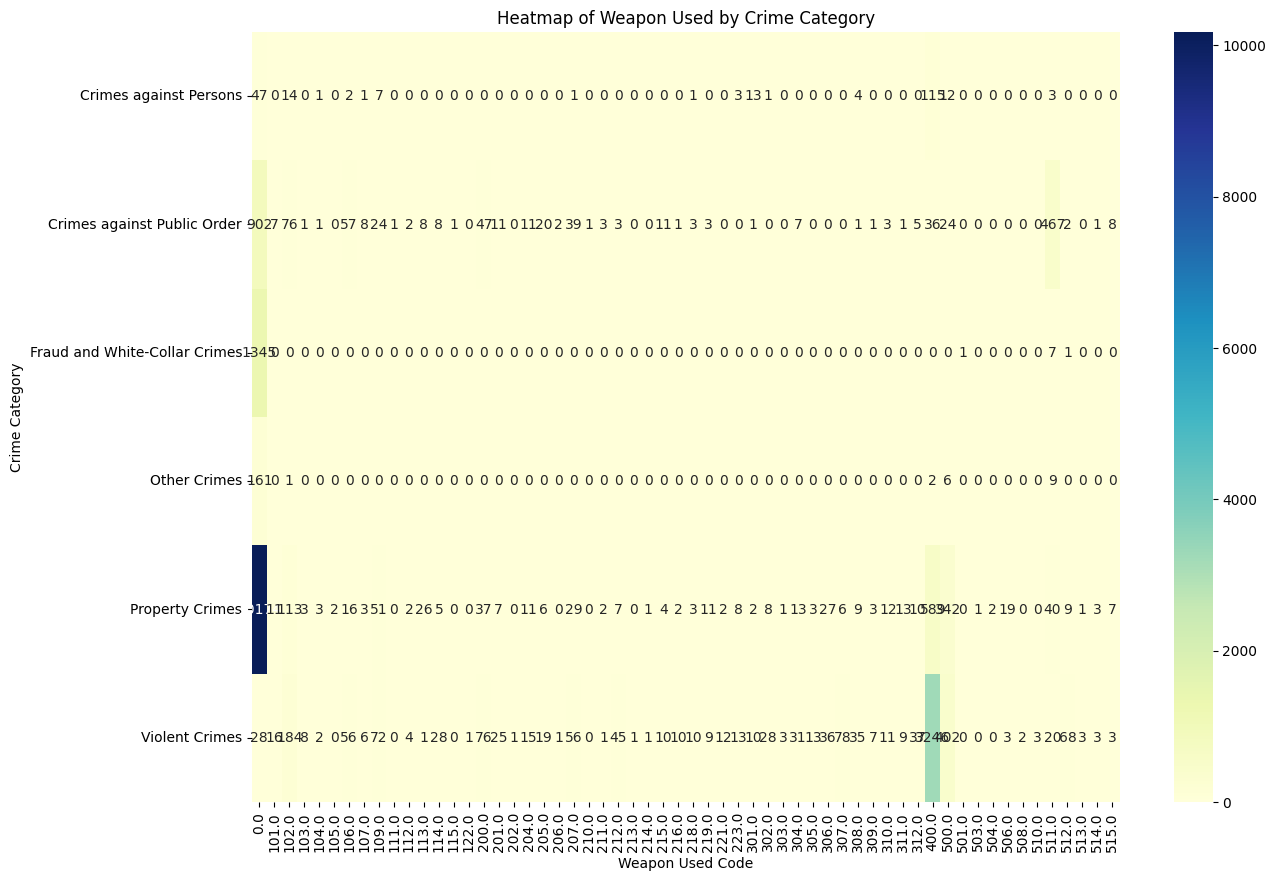

In [13]:
train_df['Weapon_Used_Code'] = train_df['Weapon_Used_Code'].fillna(0) # considering 0 as no weapon used

plt.figure(figsize=(12, 8))
sns.countplot(data=train_df, x='Crime_Category', hue='Weapon_Used_Code')
plt.title('Weapon Used in Different Crime Categories')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.legend(title='Weapon Used Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

pivot_table = pd.crosstab(train_df['Crime_Category'], train_df['Weapon_Used_Code'])
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Weapon Used by Crime Category')
plt.xlabel('Weapon Used Code')
plt.ylabel('Crime Category')
plt.show()

In [14]:
to_drop = ['Direction','Cross_Street','Weapon_Description']
# dropping columns with high missing values other than weapon code as we can assume that those crime categories don't require weapon in genunie

In [15]:
unique_combinations = train_df.drop_duplicates(subset=['Street_Number', 'Street_Name'])
consistent = unique_combinations.shape[0] == train_df['Street_Number'].nunique()
print(f"Each Street_Number corresponds to a single Street_Name: {consistent}")

unique_combinations = train_df.drop_duplicates(subset=['Area_ID', 'Area_Name'])
consistent = unique_combinations.shape[0] == train_df['Area_ID'].nunique()
print(f"Each Area_ID corresponds to a single Area_Name: {consistent}")

unique_combinations = train_df.drop_duplicates(subset=['Premise_Code', 'Premise_Description'])
consistent = unique_combinations.shape[0] == train_df['Premise_Code'].nunique()
print(f"Each Premise_Code corresponds to a single Premise_Description: {consistent}")

unique_combinations = train_df.drop_duplicates(subset=['Status', 'Status_Description'])
consistent = unique_combinations.shape[0] == train_df['Status'].nunique()
print(f"Each Status corresponds to a single Status_Description: {consistent}")

Each Street_Number corresponds to a single Street_Name: False
Each Area_ID corresponds to a single Area_Name: True
Each Premise_Code corresponds to a single Premise_Description: True
Each Status corresponds to a single Status_Description: True


In [16]:
to_drop.extend(['Area_Name','Premise_Description','Status_Description']) # Dropping same valued columns

In [17]:
street_groups = train_df.groupby('Street_Number')['Street_Name'].unique()
street_groups

Street_Number
00       [GATEWAY PLZ, 18TH, TOLUCA ESTATES, BROOKS, GA...
00000                                         [CLUB HOUSE]
00100                                          [NORMANDIE]
01200                                           [WILSHIRE]
01500                                               [92ND]
                               ...                        
9500     [NATIONAL, ZELZAH, WALL, RESEDA, MAIE, SYLMAR,...
9600     [ARLETA, LAWLEN, FIGUEROA, AIRPORT, SEPULVEDA,...
9700     [WENDOVER, SEPULVEDA, HADDON, AIRPORT, LAUREL ...
9800     [AIRPORT, BANDERA, VIDOR, LAUREL CANYON, VESPE...
9900     [SAN PEDRO, SEPULVEDA, ARLETA, JORDAN, TAMPA, ...
Name: Street_Name, Length: 267, dtype: object

My assumption that Street_Number is corresponding to Street_Name is not correct and one Street_Number is assigned with multiple Street_Names.

### Visualizing Data

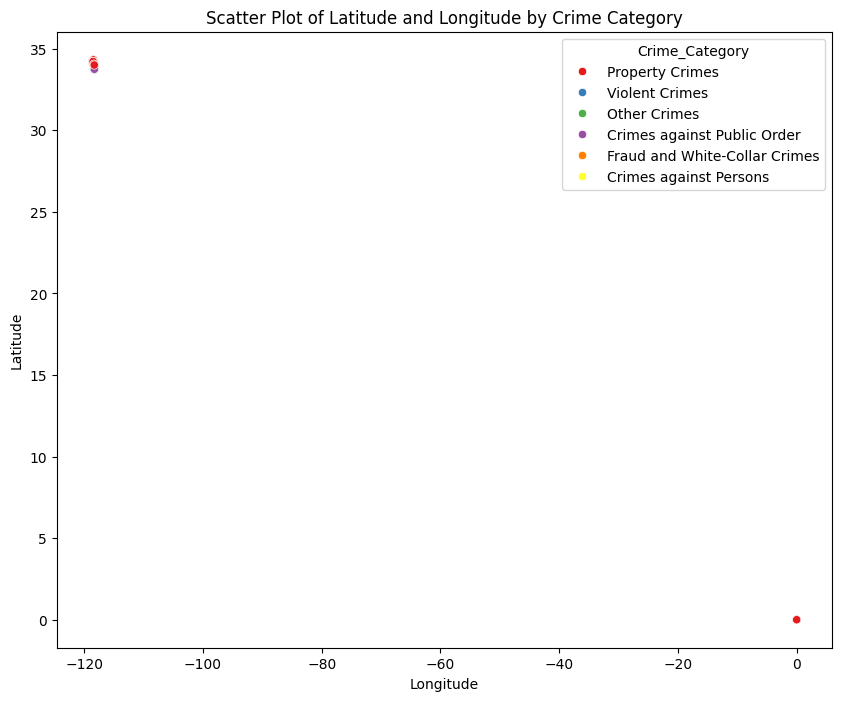

In [19]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Crime_Category', data=train_df, palette='Set1')
plt.title('Scatter Plot of Latitude and Longitude by Crime Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [23]:
print(len(train_df[train_df['Latitude']==0]), len(train_df[train_df['Latitude']==0]))
print(len(train_df[train_df['Latitude']!=0]), len(train_df[train_df['Latitude']!=0]))

78 78
19909 19909


In [27]:
train_df[['Latitude','Longitude']][train_df['Latitude']!=0].to_csv('location.csv',index=False)

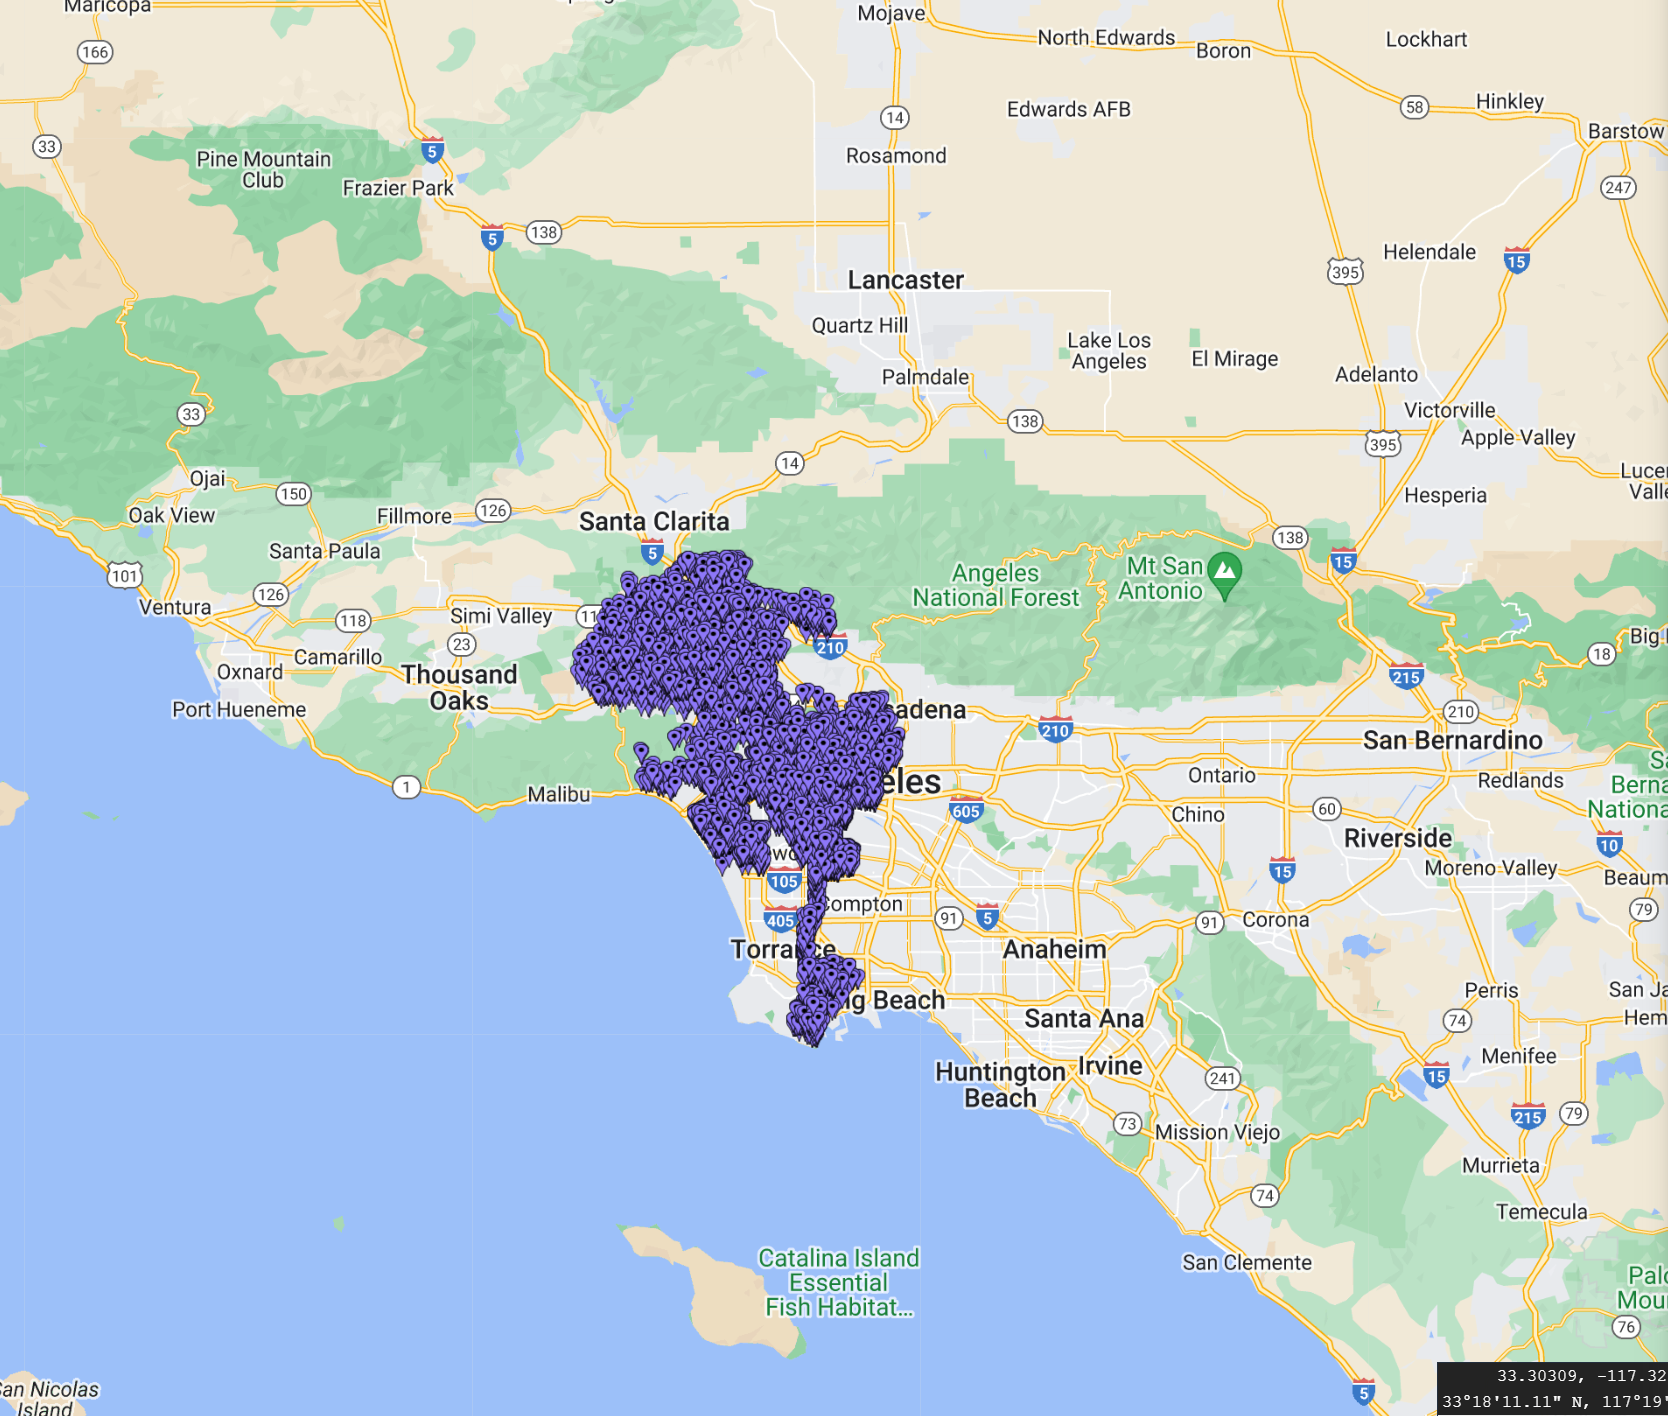

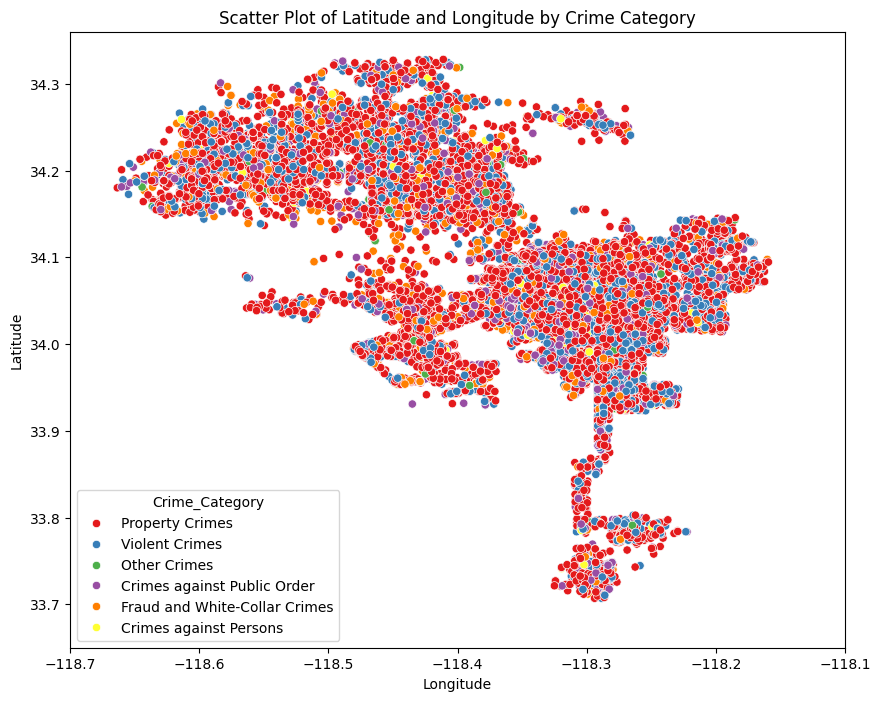

In [22]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Crime_Category', data=train_df, palette='Set1')
plt.title('Scatter Plot of Latitude and Longitude by Crime Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-118.7,-118.1); plt.ylim(33.65,34.36)
plt.show()

The dense clustering of points suggests high concentrations of crime in certain areas, with Property Crimes (red) being particularly prevalent across the region. Other crime categories, such as Violent Crimes (blue) and Crimes against Public Order (orange), are also spread throughout but with varying densities. This plot provides a clear visual representation of where different types of crimes are most commonly occurring, which could be useful for identifying high-risk areas and tailoring law enforcement efforts accordingly.

## Preprocessing

## Model Selection

In [2]:
! pip install xgboost
! pip install lightgbm

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lbg

from sklearn.metrics import accuracy_score, classification_report

In [4]:
# models = {
#     'RandomForest': RandomForestClassifier(),
#     'LogisticRegression': LogisticRegression(max_iter=1000),
#     # 'SVC': SVC(), # takingtime and low accuracy
#     # 'KNN': KNeighborsClassifier(), # low accuracy
#     'DecisionTreeClassifier': DecisionTreeClassifier(),
#     # 'GradientBoostingClassifier': GradientBoostingClassifier(), # timetaking and low accuracy
#     'XGBoost': xgb.XGBClassifier(),
#     'lightgbm': lbg.LGBMClassifier(verbose=-1),
# }
# best_model = None; best_accuracy = 0; best_model_name = ""
# for model_name, model in models.items():
#     model.fit(X_train, y_train)
#     val_predictions = model.predict(X_val)
#     accuracy = accuracy_score(y_val, val_predictions)
#     print(f"Validation Accuracy for {model_name}: {accuracy}\n")
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_model = model
#         best_model_name = model_name
# print(f"Best Model: {best_model_name}")
# print(f"Best Model Accuracy: {best_accuracy}")

In [ ]:
# model = lbg.LGBMClassifier()

# model.fit(X_train, y_train)
# val_predictions = model.predict(X_val)
# val_predictions_decoded = le.inverse_transform(val_predictions)

# # print("Classes (Original Labels):", le.classes_)
# label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
# label_mapping_df = pd.DataFrame.from_dict(label_mapping, orient='index', columns=['Encoded Value'])
# print("Label Mapping:\n", label_mapping_df)

# print("\nClassification Report: \n",classification_report(y_val, val_predictions))
# print("Accuracy: ",accuracy_score(y_val, val_predictions),'\n')

## HyperParameterTuning

## Submission

In [ ]:
# model_pipeline.fit(train_df)
# X_trans = model_pipeline.transform(train_df)
# test_df_trans = model_pipeline.transform(test_df)
# y_trans = le.fit_transform(y)

# model = lbg.LGBMClassifier(**best_params)
# model.fit(X_trans, y_trans)

# test_predictions = model.predict(test_df_trans)
# test_predictions = le.inverse_transform(test_predictions)

# submission = pd.DataFrame(
#     {
#         "ID": test_df.index+1,
#         "Crime_Category": test_predictions,
#     }
# )
# print("Submission created: ", submission.shape)
# submission.to_csv("submission.csv", index=False)